# All of the Models using padding and trimming
Set input length to 9000 \
See paddedsequence_rnn for variable length inputs

| Model | Description |
| --- | --- |
| SimpleCNN | CNN with residual connections |
| CNNWithSVM | SimpleCNN with SVM classifier |
| VorgabeRNN | CNN extractor followed by RNN then FC classifier as described in the exercise sheet |
| VorgabeLSTM | VorgabeRNN with LSTM instead of RNN |
| VorgabeGRU | VorgabeRNN with GRU instead of RNN |

In [ ]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
except ImportError:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import torch

# Modify this for your machine
DEVICE =  "cuda" if torch.cuda.is_available() else "mps"
MAIN_PATH = "/content/drive/MyDrive/ecg-timeseries-model/models/" if DEVICE == "cuda" else ""

train_df = pd.read_pickle(MAIN_PATH + "train_df.pkl")
val_df = pd.read_pickle(MAIN_PATH + "val_df.pkl")

INPUT_LENGTH = 9000
BATCH_SIZE = 64
EPOCHS = 10
NUM_WORKERS = 2 if DEVICE == "cuda" else 0
NUM_CLASSES = 4

N_FFT = 256
HOP_LENGTH = 128


CLASS_NAMES ={
    0: "Normal",
    1: "AF",
    2: "Other",
    3: "Noisy"
}


TRAINING_MEAN = 1.07e-09
TRAINING_STD = 175.11


def set_seed(seed=42):
    random.seed(seed)  # Python random
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
print("Seed set for reproducibility.")

Seed set for reproducibility.


In [ ]:
# Augmentation functions
import scipy.signal
import torch
import numpy as np

# wrapping them in nn.Module should not introduce huge overhead


def time_shift(signal, shift_range=(-100, 100)):
    shift = np.roll(signal, shift=random.randint(shift_range[0], shift_range[1]))
    return shift


def add_noise(signal, noise_level=0.1):
    noise = np.random.normal(0, noise_level, signal.shape)
    return signal + noise


def time_warp(signal, warp_factor=0.1):
    return scipy.signal.resample(
        signal, int(len(signal) * (1 + np.random.uniform(-warp_factor, warp_factor)))
    )


def amplitude_scaling(signal, scale_range=(0.8, 1.2)):
    scale = random.uniform(scale_range[0], scale_range[1])
    return signal * scale


def pad_or_trim(signal, target_length=INPUT_LENGTH):
    current_length = len(signal)

    if current_length < target_length:
        # Pad with zeros at the end
        padding = target_length - current_length
        signal = np.pad(signal, (0, padding), "constant")
    elif current_length > target_length:
        # Trim from center
        start = (current_length - target_length) // 2
        signal = signal[start : start + target_length]

    return signal


def pad_and_augment(signal, augmentation="all"):
    if augmentation in ("all", "warp_only") and np.random.rand() < 0.5:
        signal = time_warp(signal)
    signal = pad_or_trim(signal, INPUT_LENGTH)
    if augmentation in ("all", "noise_only") and np.random.rand() < 0.5:
        signal = add_noise(signal)
    if augmentation in ("all", "shift_only") and np.random.rand() < 0.5:
        signal = time_shift(signal)
    if augmentation in ("all", "scale_only") and np.random.rand() < 0.5:
        signal = amplitude_scaling(signal)
    return signal


def fourier_transform(signal):
    coeffs = np.fft.fft(signal)
    return np.abs(coeffs)


class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, df, signal_transform=None, augmentation=None):
        self.df = df
        self.signal_transform = signal_transform
        self.augmentation = augmentation
        self.target_length = (
            INPUT_LENGTH
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        assert self.signal_transform == None, "Only None is supported for now"
        signal = self.df.iloc[idx]["signal"]
        signal = np.array(signal, dtype=np.float32)
        label = int(self.df.iloc[idx]["label"])

        # keep it simple: time domain augmentation only
        signal = pad_and_augment(
            signal, self.augmentation
        )  # has padding in it. the order of augmentations should be important (wrapping changes the shape but noise and scaling before padding makes it easier to distinguish the signal length)

        signal = (signal - TRAINING_MEAN) / TRAINING_STD
        signal = torch.tensor(signal, dtype=torch.float32)



        return signal, label

In [15]:
from torch.utils.data import DataLoader

train_dataset = ECGDataset(train_df, signal_transform=None, augmentation=None)
val_dataset = ECGDataset(val_df)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    generator=torch.Generator().manual_seed(42),
)
val_loader = DataLoader(val_dataset, batch_size=32)



# get mean and std of the training set
def get_mean_std(loader):
    means = []
    stds = []
    for signals, _ in loader:
        means.append(signals.mean().item())
        stds.append(signals.std().item())
    return np.mean(means), np.mean(stds)

train_mean, train_std = get_mean_std(train_loader)
print(f"Training set - Mean: {train_mean}, Std: {train_std}")


Training set - Mean: -5.337952319071822e-05, Std: 1.0851188572970303


In [16]:
def he_init_weights(m):
    """He initialization for weights"""
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


def compute_stft_batch(x, n_fft=256, hop_length=128):
    stft = torch.stft(x, n_fft=n_fft, hop_length=hop_length, return_complex=True)
    return torch.abs(stft)

In [17]:
# add data parallelism support
import torch.nn as nn
from torch.nn.utils.rnn import PackedSequence


class VorgabeRNN(nn.Module):
    def __init__(
        self,
        hidden_size=50,
        num_layers=2,
        num_classes=NUM_CLASSES,
        n_fft=512,
        hop_length=256,
        dropout_rate=0.2,
    ):
        super(VorgabeRNN, self).__init__()

        # STFT parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_freqs = n_fft // 2 + 1  # Number of frequency bins

        self.conv1 = nn.Conv2d(1, 32, kernel_size=(7, 7), padding=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        self.conv_output_size = 64 * (
            self.n_freqs // 4
        )  # Assuming 2 pooling operations

        self.rnn = nn.RNN(
            self.conv_output_size, hidden_size, num_layers, batch_first=True
        )
        self.fc = nn.Linear(hidden_size, num_classes)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.stft = compute_stft_batch
        self.apply(he_init_weights)

        self.rnn_type = "RNN"

    def feature_extractor( self, x: torch.Tensor) -> torch.Tensor:
        x = x.squeeze(1)  # Remove the sequence dimension if present
        x = self.stft(x, n_fft=self.n_fft, hop_length=self.hop_length)

        x = torch.log1p(x + 1e-8)
        x = x.unsqueeze(1)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)

        # Reshape for RNN: (batch, time, features)
        batch_size, channels, freq_bins, time_frames = x.shape
        x = x.view(batch_size, time_frames, -1)  # Flatten freq and channel dimensions


        rnn_result = self.rnn(x)
        if self.rnn_type == "LSTM":
            lstm_hidden_state = rnn_result[1][0]  # Different variable name
            return lstm_hidden_state[-1]
        else:
            # RNN/GRU case: hidden is direct
            rnn_hidden_state = rnn_result[1]  # Different variable name
            return rnn_hidden_state[-1]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        self.eval()
        with torch.no_grad():
            x = self.forward(x)
            _, predicted = torch.max(x, 1)
        return predicted

In [18]:
class VorgabeLSTM(VorgabeRNN):
    def __init__(self, hidden_size=50, num_layers=2, num_classes=NUM_CLASSES, n_fft=512, hop_length=256, dropout_rate=0.2):
        super().__init__(hidden_size, num_layers, num_classes, n_fft, hop_length, dropout_rate)
        self.rnn = nn.LSTM(self.conv_output_size, hidden_size, num_layers, batch_first=True)
        self.rnn_type = "LSTM"

class VorgabeGRU(VorgabeRNN):
    def __init__(self, hidden_size=50, num_layers=2, num_classes=NUM_CLASSES, n_fft=512, hop_length=256, dropout_rate=0.2):
        super().__init__(hidden_size, num_layers, num_classes, n_fft, hop_length, dropout_rate)
        self.rnn = nn.GRU(self.conv_output_size, hidden_size, num_layers, batch_first=True)
        self.rnn_type = "GRU"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVC
import numpy as np
from tqdm import tqdm


class SimpleCNNwithoutClassifier(nn.Module):
    def __init__(self, feature_size=50):
        super(SimpleCNNwithoutClassifier, self).__init__()
        self.feature_size = feature_size

        self.convblock1 = nn.Sequential(
            nn.LazyConv2d(out_channels=16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.LazyConv2d(out_channels=16, kernel_size=7, padding=3),
            nn.BatchNorm2d(16),
        )
        self.conv1 = nn.LazyConv2d(out_channels=16, kernel_size=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.convblock2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        self.conv2 = nn.Conv2d(16, 32, kernel_size=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = None
        self._fc1_initialized = False

        self.apply(he_init_weights)

    def forward(self, x):
        x = x.squeeze(1)  # Remove channel dimension if present

        x = compute_stft_batch(x)  # STFT → (batch, freq, time)
        x = torch.log1p(x)  # Apply log1p transformation

        x = x.unsqueeze(1)  # (batch, 1, freq, time)

        # First residual block
        x = self.convblock1(x) + self.conv1(x)  # Residual connection
        x = nn.ReLU()(x)
        x = self.maxpool1(x)
        # Ensure the output shape is compatible with the next layer
        if x.dim() == 3:  # If the output is 3D,
            x = x.unsqueeze(1)  # Add channel dimension


        x = self.convblock2(x) + self.conv2(x)
        x = nn.ReLU()(x)
        x = self.maxpool2(x)

        if x.dim() == 3:  # If the output is 3D,
            x = x.unsqueeze(1)  # Add channel dimension

        # Flatten
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)


        if not self._fc1_initialized:
            flattened_size = x_flat.size(1)
            self.fc1 = nn.Linear(flattened_size, self.feature_size).to(x.device)
            self._fc1_initialized = True
            print(f"Initialized fc1 with input size: {flattened_size}")

        x = self.fc1(x_flat)
        return x


class SimpleCNN(nn.Module):

    def __init__(
        self,
        num_classes=NUM_CLASSES,
        feature_size=128,  # hidden_size
    ):

        super(SimpleCNN, self).__init__()
        self.num_classes = num_classes
        self.cnn_feature_extractor = SimpleCNNwithoutClassifier(
            feature_size=feature_size,
        )
        self.fc_classifier = nn.Linear(feature_size, self.num_classes)
        self.apply(he_init_weights)

    def forward(self, x):
        x = self.cnn_feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc_classifier(x)
        return x

    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            _, predicted = torch.max(x, 1)
        return predicted


class CNNwithSVM(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, feature_size=128, svm_params=None):  # hidden_size
        super().__init__()
        self.cnn_feature_extractor = SimpleCNNwithoutClassifier(
            feature_size=feature_size,
        )
        self.svm = SVC(**(svm_params or {}))
        self.is_svm_trained = False
        self._temp_classifier = None

    def forward(self, x):
        features = self.cnn_feature_extractor(x)
        if hasattr(self, "_temp_classifier") and self._temp_classifier is not None:
            return self._temp_classifier(features)
        return features

    def predict(self, x):
        if not self.is_svm_trained:
            raise ValueError("SVM not trained yet!")
        self.eval()
        with torch.no_grad():
            features = self.cnn_feature_extractor(x).cpu().numpy()
        return self.svm.predict(features)

    def _setup_temp_classifier(self, num_classes, device):
        """Add temporary classifier for CNN training"""
        feature_size = self.cnn_feature_extractor.feature_size
        self._temp_classifier = nn.Linear(feature_size, num_classes).to(device)

    def _remove_temp_classifier(self):
        """Remove temporary classifier after CNN training"""
        self._temp_classifier = None

In [20]:
from sklearn.utils.class_weight import compute_class_weight

def train_model(
    model, train_loader, epochs=10, lr=0.001, batch_size_factor=4
):
    device = "cuda" if torch.cuda.is_available() else "mps"
    model.to(device)

    is_cnn_svm = hasattr(model, "svm")
    num_classes = len(torch.unique(torch.cat([labels for _, labels in train_loader])))

    print(f"Training {'CNN+SVM' if is_cnn_svm else 'CNN'} model on {device}")

    if is_cnn_svm:
        model._setup_temp_classifier(num_classes, device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Compute class weights
    original_weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_df["label"]),
        y=train_df["label"],
    )

    scaled_weights = original_weights / original_weights.max()  # normalize to max=1
    scaled_weights = 0.5 + (scaled_weights * 0.5)  # shrink range to [0.5, 1.0] for balance

    weights_tensor = torch.tensor(scaled_weights, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=weights_tensor)

    print("Training CNN feature extractor...")
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for signals, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            signals, labels = signals.unsqueeze(1).to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        acc = 100.0 * correct / total
        print(
            f"Epoch {epoch+1}: Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {acc:.2f}%"
        )

    if is_cnn_svm:
        model._remove_temp_classifier()
        _train_svm_phase(model, train_loader, device, batch_size_factor)

    return model


def _train_svm_phase(model, train_loader, device, batch_size_factor):

    print("Training SVM...")
    model.eval()
    all_features, all_labels = [], []
    batch_features, batch_labels = [], []

    # extract_features_from_loader(model, data_loader, device):
    with torch.no_grad():
        for signals, labels in tqdm(train_loader, desc="Extracting features"):
            signals = signals.unsqueeze(1).to(device)
            features = model.cnn_feature_extractor(signals)

            batch_features.append(features)
            batch_labels.append(labels)

            if len(batch_features) >= batch_size_factor:
                combined_features = torch.cat(batch_features, dim=0).cpu().numpy()
                combined_labels = torch.cat(batch_labels, dim=0).numpy()
                all_features.append(combined_features)
                all_labels.append(combined_labels)
                batch_features, batch_labels = [], []

    # Process remaining
    if batch_features:
        combined_features = torch.cat(batch_features, dim=0).cpu().numpy()
        combined_labels = torch.cat(batch_labels, dim=0).numpy()
        all_features.append(combined_features)
        all_labels.append(combined_labels)

    final_features = np.concatenate(all_features, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)

    print(f"Training SVM on {len(final_features)} samples")
    model.svm.fit(final_features, final_labels)
    model.is_svm_trained = True

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score


def evaluate_model(model, val_loader, device):
    print("Evaluating model...")
    model.eval()
    all_predictions, all_labels = [], []
    is_cnn_svm = hasattr(model, "svm")

    with torch.no_grad():
        for signals, labels in tqdm(val_loader, desc="Evaluating"):
            signals = signals.unsqueeze(1).to(device)

            if is_cnn_svm:
                features = model.cnn_feature_extractor(signals).cpu().numpy()
                predictions = model.svm.predict(features)
            else:
                predictions = model.predict(signals)
                predictions = predictions.cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    print(f"Final Validation Accuracy: {accuracy:.4f}")
    print(classification_report(all_labels, all_predictions))

    # get overall f1 score
    f1 = f1_score(all_labels, all_predictions, average="weighted")
    print(f"Final Validation F1 Score: {f1:.4f}")

    # confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    # normalize heatmap colors in each row for class distribution
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=CLASS_NAMES.values(), yticklabels=CLASS_NAMES.values())
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


    return accuracy

Starting tests with different configurations...
Testing VorgabeRNN with None and all
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:04<00:00, 17.92it/s]


Epoch 1: Train Loss: 1.3216, Train Acc: 55.29%


Epoch 2/20: 100%|██████████| 83/83 [00:04<00:00, 18.60it/s]


Epoch 2: Train Loss: 0.9981, Train Acc: 60.43%


Epoch 3/20: 100%|██████████| 83/83 [00:06<00:00, 13.49it/s]


Epoch 3: Train Loss: 0.9440, Train Acc: 61.79%


Epoch 4/20: 100%|██████████| 83/83 [00:04<00:00, 18.12it/s]


Epoch 4: Train Loss: 0.8860, Train Acc: 64.36%


Epoch 5/20: 100%|██████████| 83/83 [00:05<00:00, 15.61it/s]


Epoch 5: Train Loss: 0.8702, Train Acc: 65.08%


Epoch 6/20: 100%|██████████| 83/83 [00:05<00:00, 15.77it/s]


Epoch 6: Train Loss: 0.8414, Train Acc: 66.30%


Epoch 7/20: 100%|██████████| 83/83 [00:04<00:00, 18.26it/s]


Epoch 7: Train Loss: 0.8302, Train Acc: 66.74%


Epoch 8/20: 100%|██████████| 83/83 [00:06<00:00, 13.33it/s]


Epoch 8: Train Loss: 0.7952, Train Acc: 68.64%


Epoch 9/20: 100%|██████████| 83/83 [00:04<00:00, 18.07it/s]


Epoch 9: Train Loss: 0.7914, Train Acc: 68.87%


Epoch 10/20: 100%|██████████| 83/83 [00:04<00:00, 18.24it/s]


Epoch 10: Train Loss: 0.7699, Train Acc: 69.54%


Epoch 11/20: 100%|██████████| 83/83 [00:06<00:00, 13.59it/s]


Epoch 11: Train Loss: 0.8610, Train Acc: 65.94%


Epoch 12/20: 100%|██████████| 83/83 [00:04<00:00, 18.74it/s]


Epoch 12: Train Loss: 0.7713, Train Acc: 69.69%


Epoch 13/20: 100%|██████████| 83/83 [00:04<00:00, 17.10it/s]


Epoch 13: Train Loss: 0.7472, Train Acc: 70.18%


Epoch 14/20: 100%|██████████| 83/83 [00:05<00:00, 14.05it/s]


Epoch 14: Train Loss: 0.7593, Train Acc: 69.06%


Epoch 15/20: 100%|██████████| 83/83 [00:04<00:00, 18.66it/s]


Epoch 15: Train Loss: 0.7496, Train Acc: 70.64%


Epoch 16/20: 100%|██████████| 83/83 [00:05<00:00, 14.64it/s]


Epoch 16: Train Loss: 0.6984, Train Acc: 72.45%


Epoch 17/20: 100%|██████████| 83/83 [00:04<00:00, 17.22it/s]


Epoch 17: Train Loss: 0.7868, Train Acc: 68.70%


Epoch 18/20: 100%|██████████| 83/83 [00:04<00:00, 16.92it/s]


Epoch 18: Train Loss: 0.7233, Train Acc: 71.00%


Epoch 19/20: 100%|██████████| 83/83 [00:06<00:00, 13.21it/s]


Epoch 19: Train Loss: 0.7049, Train Acc: 72.03%


Epoch 20/20: 100%|██████████| 83/83 [00:04<00:00, 18.17it/s]


Epoch 20: Train Loss: 0.6980, Train Acc: 71.86%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 38.09it/s]


Final Validation Accuracy: 0.7184
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       544
           1       0.48      0.57      0.52        84
           2       0.78      0.30      0.44       264
           3       0.51      0.63      0.56        35

    accuracy                           0.72       927
   macro avg       0.63      0.61      0.59       927
weighted avg       0.73      0.72      0.69       927

Final Validation F1 Score: 0.6871


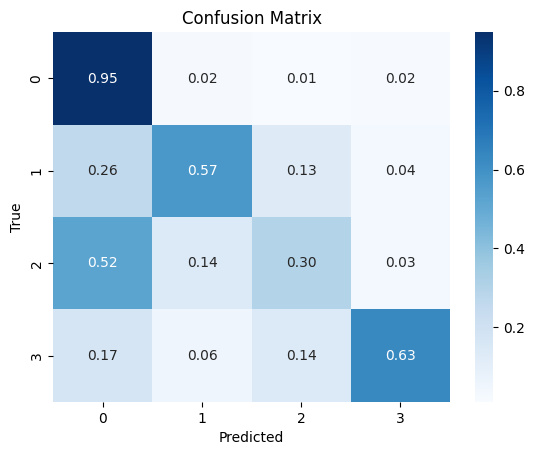

Validation Accuracy of VorgabeRNN with None and all: 0.7184

Testing VorgabeLSTM with None and all
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:06<00:00, 13.27it/s]


Epoch 1: Train Loss: 1.1179, Train Acc: 57.67%


Epoch 2/20: 100%|██████████| 83/83 [00:04<00:00, 17.86it/s]


Epoch 2: Train Loss: 0.9785, Train Acc: 60.30%


Epoch 3/20: 100%|██████████| 83/83 [00:05<00:00, 16.42it/s]


Epoch 3: Train Loss: 0.9430, Train Acc: 62.62%


Epoch 4/20: 100%|██████████| 83/83 [00:05<00:00, 14.39it/s]


Epoch 4: Train Loss: 0.9215, Train Acc: 62.74%


Epoch 5/20: 100%|██████████| 83/83 [00:04<00:00, 18.49it/s]


Epoch 5: Train Loss: 0.9067, Train Acc: 63.12%


Epoch 6/20: 100%|██████████| 83/83 [00:05<00:00, 14.34it/s]


Epoch 6: Train Loss: 0.8786, Train Acc: 64.64%


Epoch 7/20: 100%|██████████| 83/83 [00:04<00:00, 17.04it/s]


Epoch 7: Train Loss: 0.8835, Train Acc: 64.11%


Epoch 8/20: 100%|██████████| 83/83 [00:04<00:00, 18.61it/s]


Epoch 8: Train Loss: 0.8750, Train Acc: 64.83%


Epoch 9/20: 100%|██████████| 83/83 [00:06<00:00, 13.04it/s]


Epoch 9: Train Loss: 0.8529, Train Acc: 65.50%


Epoch 10/20: 100%|██████████| 83/83 [00:04<00:00, 17.66it/s]


Epoch 10: Train Loss: 0.8841, Train Acc: 64.62%


Epoch 11/20: 100%|██████████| 83/83 [00:04<00:00, 18.05it/s]


Epoch 11: Train Loss: 0.8562, Train Acc: 65.46%


Epoch 12/20: 100%|██████████| 83/83 [00:06<00:00, 13.37it/s]


Epoch 12: Train Loss: 0.8514, Train Acc: 66.01%


Epoch 13/20: 100%|██████████| 83/83 [00:04<00:00, 17.95it/s]


Epoch 13: Train Loss: 0.8446, Train Acc: 65.25%


Epoch 14/20: 100%|██████████| 83/83 [00:05<00:00, 15.01it/s]


Epoch 14: Train Loss: 0.8211, Train Acc: 66.32%


Epoch 15/20: 100%|██████████| 83/83 [00:05<00:00, 15.96it/s]


Epoch 15: Train Loss: 0.8337, Train Acc: 66.39%


Epoch 16/20: 100%|██████████| 83/83 [00:04<00:00, 18.58it/s]


Epoch 16: Train Loss: 0.8185, Train Acc: 67.14%


Epoch 17/20: 100%|██████████| 83/83 [00:06<00:00, 12.64it/s]


Epoch 17: Train Loss: 0.8071, Train Acc: 67.82%


Epoch 18/20: 100%|██████████| 83/83 [00:04<00:00, 17.74it/s]


Epoch 18: Train Loss: 0.8130, Train Acc: 67.35%


Epoch 19/20: 100%|██████████| 83/83 [00:04<00:00, 18.23it/s]


Epoch 19: Train Loss: 0.7973, Train Acc: 68.32%


Epoch 20/20: 100%|██████████| 83/83 [00:06<00:00, 12.40it/s]


Epoch 20: Train Loss: 0.7988, Train Acc: 68.51%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 34.67it/s]


Final Validation Accuracy: 0.6936
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       544
           1       0.82      0.11      0.19        84
           2       0.56      0.50      0.53       264
           3       0.46      0.77      0.57        35

    accuracy                           0.69       927
   macro avg       0.65      0.56      0.53       927
weighted avg       0.70      0.69      0.67       927

Final Validation F1 Score: 0.6679


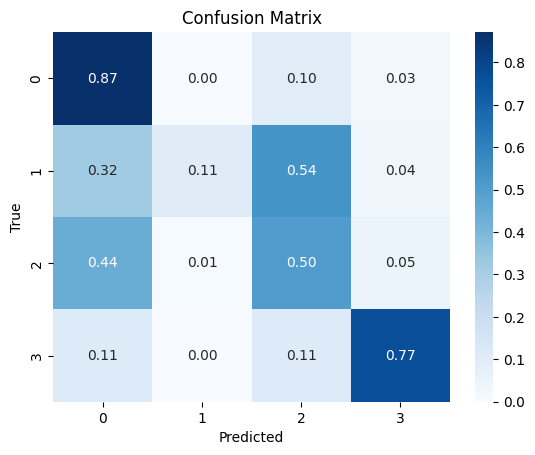

Validation Accuracy of VorgabeLSTM with None and all: 0.6936

Testing VorgabeGRU with None and all
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20: 100%|██████████| 83/83 [00:05<00:00, 14.88it/s]


Epoch 1: Train Loss: 1.1830, Train Acc: 58.21%


Epoch 2/20: 100%|██████████| 83/83 [00:05<00:00, 16.06it/s]


Epoch 2: Train Loss: 0.9931, Train Acc: 60.13%


Epoch 3/20: 100%|██████████| 83/83 [00:04<00:00, 17.97it/s]


Epoch 3: Train Loss: 0.9622, Train Acc: 60.30%


Epoch 4/20: 100%|██████████| 83/83 [00:06<00:00, 13.18it/s]


Epoch 4: Train Loss: 0.9331, Train Acc: 62.95%


Epoch 5/20: 100%|██████████| 83/83 [00:04<00:00, 17.94it/s]


Epoch 5: Train Loss: 0.9380, Train Acc: 62.11%


Epoch 6/20: 100%|██████████| 83/83 [00:04<00:00, 17.85it/s]


Epoch 6: Train Loss: 0.8876, Train Acc: 65.12%


Epoch 7/20: 100%|██████████| 83/83 [00:06<00:00, 13.26it/s]


Epoch 7: Train Loss: 0.8874, Train Acc: 64.22%


Epoch 8/20: 100%|██████████| 83/83 [00:04<00:00, 18.34it/s]


Epoch 8: Train Loss: 0.8456, Train Acc: 65.75%


Epoch 9/20: 100%|██████████| 83/83 [00:04<00:00, 17.25it/s]


Epoch 9: Train Loss: 0.8794, Train Acc: 65.42%


Epoch 10/20: 100%|██████████| 83/83 [00:05<00:00, 13.93it/s]


Epoch 10: Train Loss: 0.8265, Train Acc: 66.58%


Epoch 11/20: 100%|██████████| 83/83 [00:04<00:00, 18.19it/s]


Epoch 11: Train Loss: 0.8131, Train Acc: 67.54%


Epoch 12/20: 100%|██████████| 83/83 [00:05<00:00, 13.93it/s]


Epoch 12: Train Loss: 0.8239, Train Acc: 66.74%


Epoch 13/20: 100%|██████████| 83/83 [00:04<00:00, 16.79it/s]


Epoch 13: Train Loss: 0.7919, Train Acc: 67.73%


Epoch 14/20: 100%|██████████| 83/83 [00:04<00:00, 17.95it/s]


Epoch 14: Train Loss: 0.7810, Train Acc: 68.22%


Epoch 15/20: 100%|██████████| 83/83 [00:06<00:00, 13.32it/s]


Epoch 15: Train Loss: 0.7632, Train Acc: 69.46%


Epoch 16/20: 100%|██████████| 83/83 [00:04<00:00, 18.25it/s]


Epoch 16: Train Loss: 0.7523, Train Acc: 69.23%


Epoch 17/20: 100%|██████████| 83/83 [00:05<00:00, 16.32it/s]


Epoch 17: Train Loss: 0.7627, Train Acc: 69.44%


Epoch 18/20: 100%|██████████| 83/83 [00:06<00:00, 13.66it/s]


Epoch 18: Train Loss: 0.7641, Train Acc: 69.17%


Epoch 19/20: 100%|██████████| 83/83 [00:04<00:00, 18.67it/s]


Epoch 19: Train Loss: 0.7305, Train Acc: 70.53%


Epoch 20/20: 100%|██████████| 83/83 [00:05<00:00, 15.30it/s]


Epoch 20: Train Loss: 0.7273, Train Acc: 70.87%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 25.00it/s]


Final Validation Accuracy: 0.7260
              precision    recall  f1-score   support

           0       0.77      0.91      0.84       544
           1       0.58      0.35      0.43        84
           2       0.63      0.46      0.53       264
           3       0.66      0.71      0.68        35

    accuracy                           0.73       927
   macro avg       0.66      0.61      0.62       927
weighted avg       0.71      0.73      0.71       927

Final Validation F1 Score: 0.7073


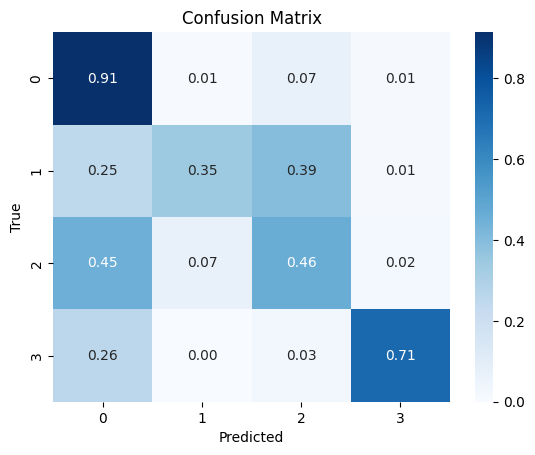

Validation Accuracy of VorgabeGRU with None and all: 0.7260

Testing CNNwithSVM with None and all
Training CNN+SVM model on cuda
Training CNN feature extractor...


Epoch 1/20:   0%|          | 0/83 [00:00<?, ?it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:09<00:00,  8.71it/s]


Epoch 1: Train Loss: 1.0479, Train Acc: 59.37%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  9.17it/s]


Epoch 2: Train Loss: 0.9119, Train Acc: 65.18%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  8.97it/s]


Epoch 3: Train Loss: 0.8459, Train Acc: 67.38%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  9.18it/s]


Epoch 4: Train Loss: 0.7854, Train Acc: 70.32%


Epoch 5/20: 100%|██████████| 83/83 [00:08<00:00,  9.26it/s]


Epoch 5: Train Loss: 0.7596, Train Acc: 71.33%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  9.08it/s]


Epoch 6: Train Loss: 0.7481, Train Acc: 71.55%


Epoch 7/20: 100%|██████████| 83/83 [00:08<00:00,  9.56it/s]


Epoch 7: Train Loss: 0.7336, Train Acc: 71.74%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  8.96it/s]


Epoch 8: Train Loss: 0.7134, Train Acc: 72.47%


Epoch 9/20: 100%|██████████| 83/83 [00:09<00:00,  9.02it/s]


Epoch 9: Train Loss: 0.7111, Train Acc: 73.46%


Epoch 10/20: 100%|██████████| 83/83 [00:08<00:00,  9.50it/s]


Epoch 10: Train Loss: 0.6870, Train Acc: 73.69%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  9.00it/s]


Epoch 11: Train Loss: 0.6821, Train Acc: 73.40%


Epoch 12/20: 100%|██████████| 83/83 [00:09<00:00,  9.10it/s]


Epoch 12: Train Loss: 0.6665, Train Acc: 73.84%


Epoch 13/20: 100%|██████████| 83/83 [00:08<00:00,  9.36it/s]


Epoch 13: Train Loss: 0.6507, Train Acc: 75.38%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  9.12it/s]


Epoch 14: Train Loss: 0.6421, Train Acc: 75.42%


Epoch 15/20: 100%|██████████| 83/83 [00:09<00:00,  9.02it/s]


Epoch 15: Train Loss: 0.6494, Train Acc: 74.90%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  9.18it/s]


Epoch 16: Train Loss: 0.6441, Train Acc: 75.55%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  8.96it/s]


Epoch 17: Train Loss: 0.6369, Train Acc: 75.65%


Epoch 18/20: 100%|██████████| 83/83 [00:08<00:00,  9.24it/s]


Epoch 18: Train Loss: 0.6194, Train Acc: 76.39%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  9.20it/s]


Epoch 19: Train Loss: 0.6046, Train Acc: 76.96%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.91it/s]


Epoch 20: Train Loss: 0.5992, Train Acc: 76.85%
Training SVM...


Extracting features: 100%|██████████| 83/83 [00:04<00:00, 20.08it/s]


Training SVM on 5252 samples
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 22.12it/s]


Final Validation Accuracy: 0.7465
              precision    recall  f1-score   support

           0       0.76      0.95      0.85       544
           1       0.76      0.49      0.59        84
           2       0.71      0.44      0.54       264
           3       0.64      0.51      0.57        35

    accuracy                           0.75       927
   macro avg       0.72      0.60      0.64       927
weighted avg       0.74      0.75      0.72       927

Final Validation F1 Score: 0.7247


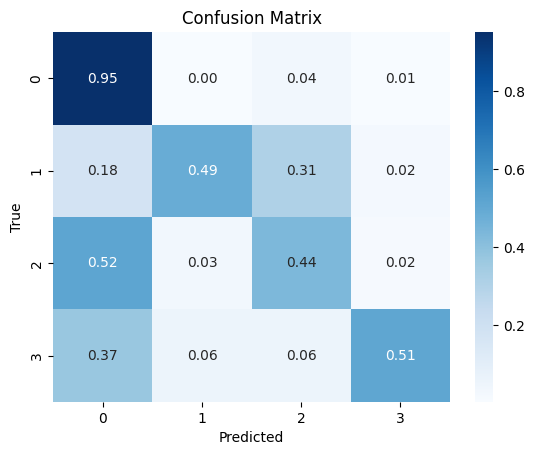

Validation Accuracy of CNNwithSVM with None and all: 0.7465

Testing SimpleCNN with None and all
Training CNN model on cuda
Training CNN feature extractor...


Epoch 1/20:   1%|          | 1/83 [00:00<00:34,  2.39it/s]

Initialized fc1 with input size: 17408


Epoch 1/20: 100%|██████████| 83/83 [00:08<00:00,  9.40it/s]


Epoch 1: Train Loss: 1.0949, Train Acc: 59.35%


Epoch 2/20: 100%|██████████| 83/83 [00:09<00:00,  9.05it/s]


Epoch 2: Train Loss: 0.8975, Train Acc: 65.67%


Epoch 3/20: 100%|██████████| 83/83 [00:09<00:00,  9.12it/s]


Epoch 3: Train Loss: 0.8717, Train Acc: 65.58%


Epoch 4/20: 100%|██████████| 83/83 [00:09<00:00,  9.07it/s]


Epoch 4: Train Loss: 0.8412, Train Acc: 68.09%


Epoch 5/20: 100%|██████████| 83/83 [00:09<00:00,  8.89it/s]


Epoch 5: Train Loss: 0.8267, Train Acc: 66.98%


Epoch 6/20: 100%|██████████| 83/83 [00:09<00:00,  9.21it/s]


Epoch 6: Train Loss: 0.7923, Train Acc: 68.58%


Epoch 7/20: 100%|██████████| 83/83 [00:09<00:00,  9.14it/s]


Epoch 7: Train Loss: 0.7785, Train Acc: 68.35%


Epoch 8/20: 100%|██████████| 83/83 [00:09<00:00,  9.09it/s]


Epoch 8: Train Loss: 0.7506, Train Acc: 70.54%


Epoch 9/20: 100%|██████████| 83/83 [00:08<00:00,  9.31it/s]


Epoch 9: Train Loss: 0.7386, Train Acc: 71.04%


Epoch 10/20: 100%|██████████| 83/83 [00:10<00:00,  7.72it/s]


Epoch 10: Train Loss: 0.7221, Train Acc: 72.18%


Epoch 11/20: 100%|██████████| 83/83 [00:09<00:00,  8.43it/s]


Epoch 11: Train Loss: 0.7331, Train Acc: 71.92%


Epoch 12/20: 100%|██████████| 83/83 [00:08<00:00,  9.33it/s]


Epoch 12: Train Loss: 0.7182, Train Acc: 71.93%


Epoch 13/20: 100%|██████████| 83/83 [00:09<00:00,  9.12it/s]


Epoch 13: Train Loss: 0.7149, Train Acc: 72.56%


Epoch 14/20: 100%|██████████| 83/83 [00:09<00:00,  9.08it/s]


Epoch 14: Train Loss: 0.6914, Train Acc: 73.00%


Epoch 15/20: 100%|██████████| 83/83 [00:08<00:00,  9.29it/s]


Epoch 15: Train Loss: 0.6863, Train Acc: 72.89%


Epoch 16/20: 100%|██████████| 83/83 [00:09<00:00,  9.02it/s]


Epoch 16: Train Loss: 0.6962, Train Acc: 73.40%


Epoch 17/20: 100%|██████████| 83/83 [00:09<00:00,  9.05it/s]


Epoch 17: Train Loss: 0.7060, Train Acc: 73.42%


Epoch 18/20: 100%|██████████| 83/83 [00:08<00:00,  9.45it/s]


Epoch 18: Train Loss: 0.6890, Train Acc: 73.46%


Epoch 19/20: 100%|██████████| 83/83 [00:09<00:00,  8.94it/s]


Epoch 19: Train Loss: 0.6575, Train Acc: 74.22%


Epoch 20/20: 100%|██████████| 83/83 [00:09<00:00,  8.97it/s]


Epoch 20: Train Loss: 0.6628, Train Acc: 73.71%
Evaluating model...


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 32.53it/s]


Final Validation Accuracy: 0.5933
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       544
           1       0.25      0.83      0.38        84
           2       0.66      0.29      0.41       264
           3       0.24      0.60      0.35        35

    accuracy                           0.59       927
   macro avg       0.50      0.61      0.48       927
weighted avg       0.73      0.59      0.62       927

Final Validation F1 Score: 0.6174


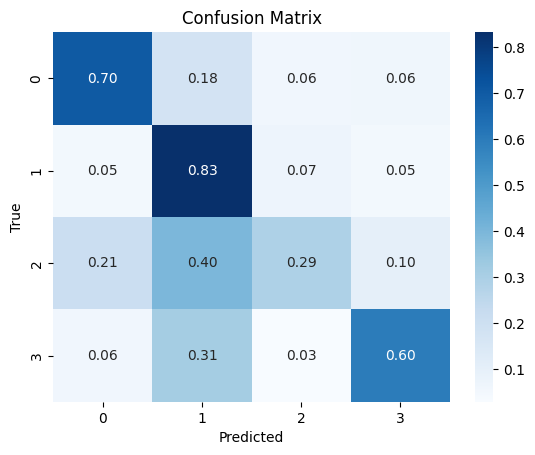

Validation Accuracy of SimpleCNN with None and all: 0.5933

All tests completed.
Best result:
Model: CNNwithSVM, Signal Transform: None, Augmentation: all, Accuracy: 0.7465


In [21]:
test_space = {
    "model": [
        VorgabeRNN,
        VorgabeLSTM,
        VorgabeGRU,
        CNNwithSVM,
        SimpleCNN,
    ],
    "signal_transform": [None],
    "augmentation": ["all"],
}

results = []
print("Starting tests with different configurations...")

device = "cuda" if torch.cuda.is_available() else "mps"

for signal_transform in test_space["signal_transform"]:
    for augmentation in test_space["augmentation"]:
        train_set = ECGDataset(train_df, signal_transform=signal_transform, augmentation=augmentation)
        val_set = ECGDataset(val_df, signal_transform=signal_transform)
        train_loader = DataLoader(train_set,
                                  batch_size=BATCH_SIZE,
                                  num_workers=NUM_WORKERS,
                                  shuffle=True,
                                  generator=torch.Generator().manual_seed(42))

        val_loader = DataLoader(val_set,
                                batch_size=BATCH_SIZE,
                                num_workers=NUM_WORKERS,
                                shuffle=False)

        for model_cls in test_space["model"]:
            print(f"Testing {model_cls.__name__} with {signal_transform} and {augmentation}")
            if issubclass(model_cls, VorgabeRNN):
                model = model_cls(
                    hidden_size=128,
                    num_layers=1,
                    num_classes=NUM_CLASSES,
                    n_fft=256,
                    hop_length=128,
                    dropout_rate=0.0,
                )
            else:
                model = model_cls(
                    feature_size=50,
                    num_classes=NUM_CLASSES
                )
            model.to(device)
            trained_model = train_model(model, train_loader, epochs=20, lr=0.001, batch_size_factor=4)
            acc = evaluate_model(trained_model, val_loader, device)
            print(f"Validation Accuracy of {model_cls.__name__} with {signal_transform} and {augmentation}: {acc:.4f}\n")
            results.append({
                "model": model_cls.__name__,
                "signal_transform": signal_transform,
                "augmentation": augmentation,
                "accuracy": acc,
            })
            del trained_model
            torch.cuda.empty_cache()
        del train_set, val_set, train_loader, val_loader

print("All tests completed.")
best_result = max(results, key=lambda x: x["accuracy"])
print(f"Best result:\nModel: {best_result['model']}, Signal Transform: {best_result['signal_transform']}, Augmentation: {best_result['augmentation']}, Accuracy: {best_result['accuracy']:.4f}")